<a href="https://colab.research.google.com/github/AndyIsHigh0608/RecruitmentMLTestSubmission/blob/main/Copy_of_RecruitmentMLTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# from google.colab import files
# files.upload()

In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, silhouette_samples
from matplotlib import pyplot as plt
from scipy.stats import kurtosis, skew, boxcox
from yellowbrick.cluster import KElbowVisualizer
from typing import List, Optional

In [4]:
orders_df = pd.read_parquet('/content/drive/MyDrive/orders.parquet')

In [5]:
orders_df.shape

(3927651, 4)

The dataset consists of 3927651 rows and 4 columns.

In [6]:
orders_df.head()

,id,created_at,sales_amount,customer_id
0,29503467,2024-12-30 19:24:05,3.45,2937655
1,29511871,2024-12-30 22:09:52,3.45,1865364
2,29517274,2024-12-31 08:30:45,3.45,896267
3,29561364,2024-12-31 16:35:49,3.45,4077636
4,29562591,2024-12-31 16:50:58,3.45,124644


In [7]:
orders_df.describe()

,created_at,sales_amount
count,3927651,3.927651e+06
mean,2024-07-19 23:52:36.632740608,1.549553e+01
min,2024-01-01 06:10:16,3.020000e+00
25%,2024-04-18 13:02:56,8.910000e+00
50%,2024-07-26 12:22:03,1.161000e+01
75%,2024-10-27 13:15:14.500000,1.904000e+01
max,2024-12-31 23:51:17,7.239000e+02
std,NaN,1.183016e+01


In [8]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3927651 entries, 0 to 3927650
Data columns (total 4 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            object        
 1   created_at    datetime64[ns]
 2   sales_amount  float64       
 3   customer_id   object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 119.9+ MB


In [9]:
def display_null_summary(df) -> None:
    null_counts = df.isnull().sum()
    null_percentage = (null_counts / len(df)) * 100

    summary = pd.DataFrame({
        'Null Count': null_counts,
        'Null Percentage (%)': null_percentage.round(2)
    })

    summary = summary[summary['Null Count'] > 0].sort_values(by='Null Count', ascending=False)

    if summary.empty:
        print("No missing values found.")
    else:
        print("Null Value Summary:")
        print(summary)

In [10]:
display_null_summary(orders_df)

No missing values found.


There is **no missing values** found in the datasets across **all 4 columns**.

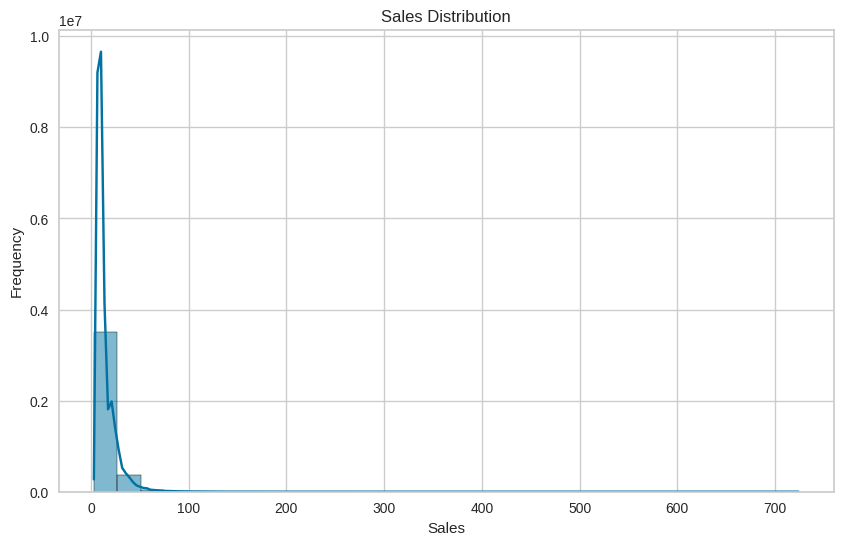

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(data=orders_df, x='sales_amount', kde=True, bins=30)
plt.title("Sales Distribution")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.show()

The sales distribution is **highly right-skewed (positively skewed)**. Most of the **sales values are concentrated near zero**, with **a long tail extending to the right**, indicating the presence of **a few very large sales outliers**. This suggests that **a small number of transactions account for disproportionately high sales**, while the majority of transactions have relatively low sales values.


In [12]:
orders_df['month'] = orders_df['created_at'].dt.month
sales_by_month = orders_df.groupby(by='month', as_index=False).agg(total_sales=('sales_amount', 'sum'))

Text(0.5, 1.0, 'Total Sales by Month')

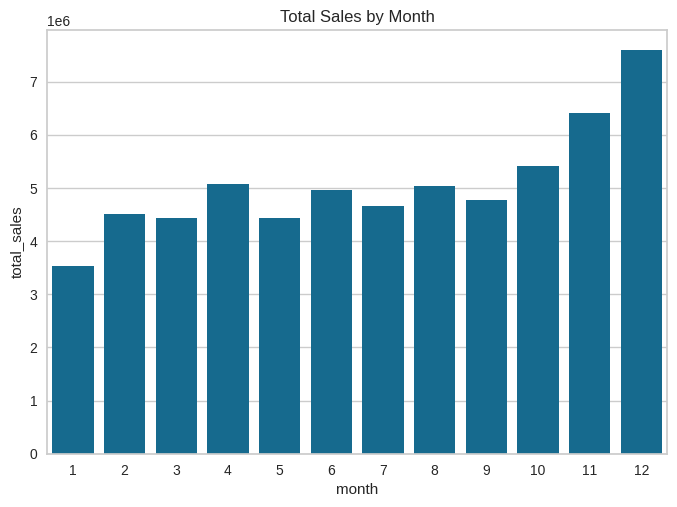

In [13]:
ax = sns.barplot(data=sales_by_month, x='month', y='total_sales')
ax.set_title('Total Sales by Month')

The bar chart shows **total sales by month**, and it reveals a **clear upward trend toward the end of the year**:

* **December** records the **highest sales**, followed by **November** and **October**, suggesting strong year-end performance—possibly due to holiday or festive shopping.
* **January** has the **lowest sales**, which may indicate a post-holiday slowdown.
* Sales remain relatively stable from **March to September**, with moderate fluctuations.


In [14]:
print('Earliest date in the dataset:', orders_df['created_at'].min())
print('Latest date in the dataset:', orders_df['created_at'].max())

Earliest date in the dataset: 2024-01-01 06:10:16
Latest date in the dataset: 2024-12-31 23:51:17


The dataset span from **2024-01-01** to **2024-12-31**



<h2> RFM Transformation </h2>

**Customer Recency**

In [15]:

orders_df['last_purchase_date'] = orders_df.groupby(by='customer_id')['created_at'].transform('max')
orders_df['last_purchase_date'] = pd.to_datetime(orders_df['last_purchase_date'])

orders_df['customer_recency'] = (orders_df['created_at'] - orders_df['last_purchase_date']).dt.days.abs()

orders_df.head()

,id,created_at,sales_amount,customer_id,month,last_purchase_date,customer_recency
0,29503467,2024-12-30 19:24:05,3.45,2937655,12,2024-12-31 15:15:46,1
1,29511871,2024-12-30 22:09:52,3.45,1865364,12,2024-12-31 13:09:06,1
2,29517274,2024-12-31 08:30:45,3.45,896267,12,2024-12-31 20:36:40,1
3,29561364,2024-12-31 16:35:49,3.45,4077636,12,2024-12-31 16:35:49,0
4,29562591,2024-12-31 16:50:58,3.45,124644,12,2024-12-31 18:23:52,1


In [16]:
recency_df = orders_df.groupby(by='customer_id', as_index=False).agg(customer_recency=('customer_recency', 'mean'))

In [17]:
recency_df.shape

(730485, 2)

In [18]:
recency_df.head()

,customer_id,customer_recency
0,1000015,159.750000
1,100002,204.400000
2,1000020,139.666667
3,1000029,155.200000
4,1000035,142.500000


In [19]:
print(f"Skewness of the recency distribution: {skew(recency_df['customer_recency'])}")
print(f"Kurtosis of the recency distribution: {kurtosis(recency_df['customer_recency'])}")

Skewness of the recency distribution: 1.13677840434434
Kurtosis of the recency distribution: 0.13092237425130326


* **Skewness: 1.136** – This indicates a **moderate right skew**, meaning most customers have low recency (i.e., they purchased recently), while a smaller group has much higher recency values (i.e., they haven't purchased in a long time).
* **Kurtosis: 0.130** – This is close to 0, suggesting the distribution has a **normal-like peak**, but with **slightly heavier tails** than a perfect normal distribution.

In [20]:
recency_df['recency_sqrt'] = np.sqrt(recency_df['customer_recency'])
recency_df['recency_log'] = np.log1p(recency_df['customer_recency'])


To reduce skewness and stabilize variance for clustering:

* **Square Root Transformation** – Useful for moderate skewness; it can slightly compress larger values while preserving overall distribution shape.
* **Log Transformation** – More effective if the skewness persists or if there are extreme outliers, as it compresses high values more aggressively.

In [21]:
recency_skewness = skew(recency_df['customer_recency'])
recency_kurtosis = kurtosis(recency_df['customer_recency'])
recency_sqrt_skewness = skew(recency_df['recency_sqrt'])
recency_sqrt_kurtosis = kurtosis(recency_df['recency_sqrt'])
recency_log_skewness = skew(recency_df['recency_log'])
recency_log_kurtosis = kurtosis(recency_df['recency_log'])

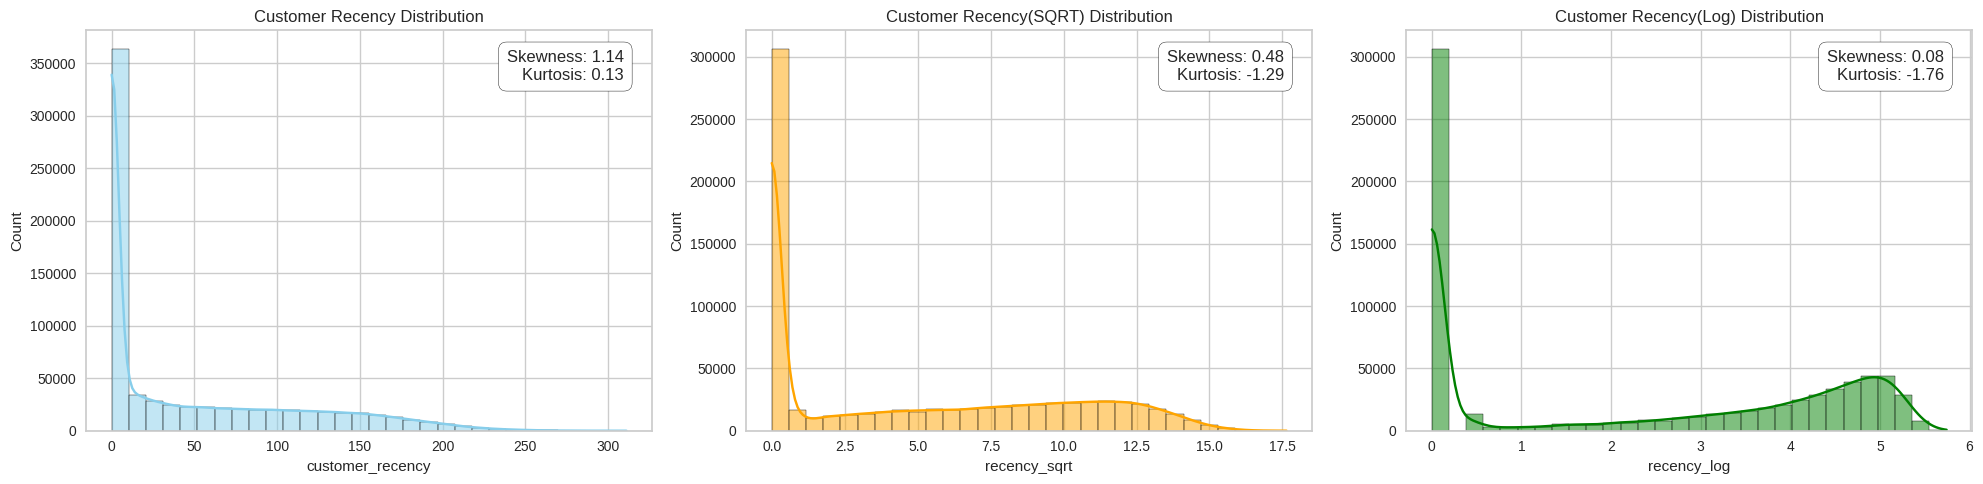

In [22]:
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(20,5))

ax1 = sns.histplot(data=recency_df, x='customer_recency', kde=True, bins=30, ax=ax1, color='skyblue')
ax1.set_title('Customer Recency Distribution')

ax1.text(
    0.95, 0.95,
    f"Skewness: {recency_skewness:.2f}\nKurtosis: {recency_kurtosis:.2f}",
    transform=ax1.transAxes,
    fontsize=12,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)


ax2 = sns.histplot(data=recency_df, x='recency_sqrt', kde=True, bins=30, ax=ax2, color='orange')
ax2.set_title('Customer Recency(SQRT) Distribution')

ax2.text(
    0.95, 0.95,
    f"Skewness: {recency_sqrt_skewness:.2f}\nKurtosis: {recency_sqrt_kurtosis:.2f}",
    transform=ax2.transAxes,
    fontsize=12,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)


ax3 = sns.histplot(data=recency_df, x='recency_log', kde=True, bins=30, ax=ax3, color='green')
ax3.set_title('Customer Recency(Log) Distribution')

ax3.text(
    0.95, 0.95,
    f"Skewness: {recency_log_skewness:.2f}\nKurtosis: {recency_log_kurtosis:.2f}",
    transform=ax3.transAxes,
    fontsize=12,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)

plt.tight_layout()

The image compares the distribution of customer recency using three transformations:

1. **Original Distribution**

   * **Skewness: 1.14**, **Kurtosis: 0.13**
   * Heavily right-skewed, with most customers making recent purchases and a long tail of inactive customers.

2. **Square Root Transformation**

   * **Skewness: 0.48**, **Kurtosis: -1.29**
   * Skewness is reduced, but the distribution remains slightly asymmetric. Tail compression is moderate.

3. **Log Transformation**

   * **Skewness: 0.08**, **Kurtosis: -1.76**
   * Most effective at reducing skewness and producing a near-symmetric distribution. The tail is significantly compressed, making it suitable for clustering or modeling.

While both transformations help normalize the data, **log transformation yields the best symmetry** and is likely the most appropriate for further analysis.


**Frequency**

In [23]:
frequency_df = orders_df.groupby(by='customer_id', as_index=False).agg(frequencies=('id', 'nunique'))
frequency_df.head()

,customer_id,frequencies
0,1000015,4
1,100002,20
2,1000020,6
3,1000029,55
4,1000035,8


In [24]:
frequency_df['frequencies'].max()

946

In [25]:
frequency_df['frequencies'].min()

1

In [26]:
print(f"Skewness of the recency distribution: {skew(frequency_df['frequencies'])}")
print(f"Kurtosis of the recency distribution: {kurtosis(frequency_df['frequencies'])}")

Skewness of the recency distribution: 9.081496683034743
Kurtosis of the recency distribution: 181.483380524286


* **Skewness: 9.08** – Indicates a **very strong right skew**, meaning a small number of customers make purchases very frequently, while the vast majority make very few purchases.
* **Kurtosis: 181.48** – Extremely high kurtosis suggests the distribution has **a sharp peak and heavy tails**, highlighting the presence of extreme outliers.


In [27]:
frequency_df['frequencies_log'] = np.log1p(frequency_df['frequencies'])
frequency_df['frequencies_boxcox'], fitted_lambda = boxcox(frequency_df['frequencies'])
print("Fitted lambda for Box-Cox:", fitted_lambda)

Fitted lambda for Box-Cox: -0.5397691773754507


To reduce skewness for better clustering:

1. **Log Transformation**

   * Useful for **reducing skewness** by compressing the scale of high values.

2. **Box-Cox Transformation**

   * More flexible than log, as it automatically selects the **optimal lambda parameter** to normalize the data.

In [28]:
frequency_skewness = skew(frequency_df['frequencies'])
frequency_log_skewness = skew(frequency_df['frequencies_log'])
frequency_boxcox_skewness = skew(frequency_df['frequencies_boxcox'])

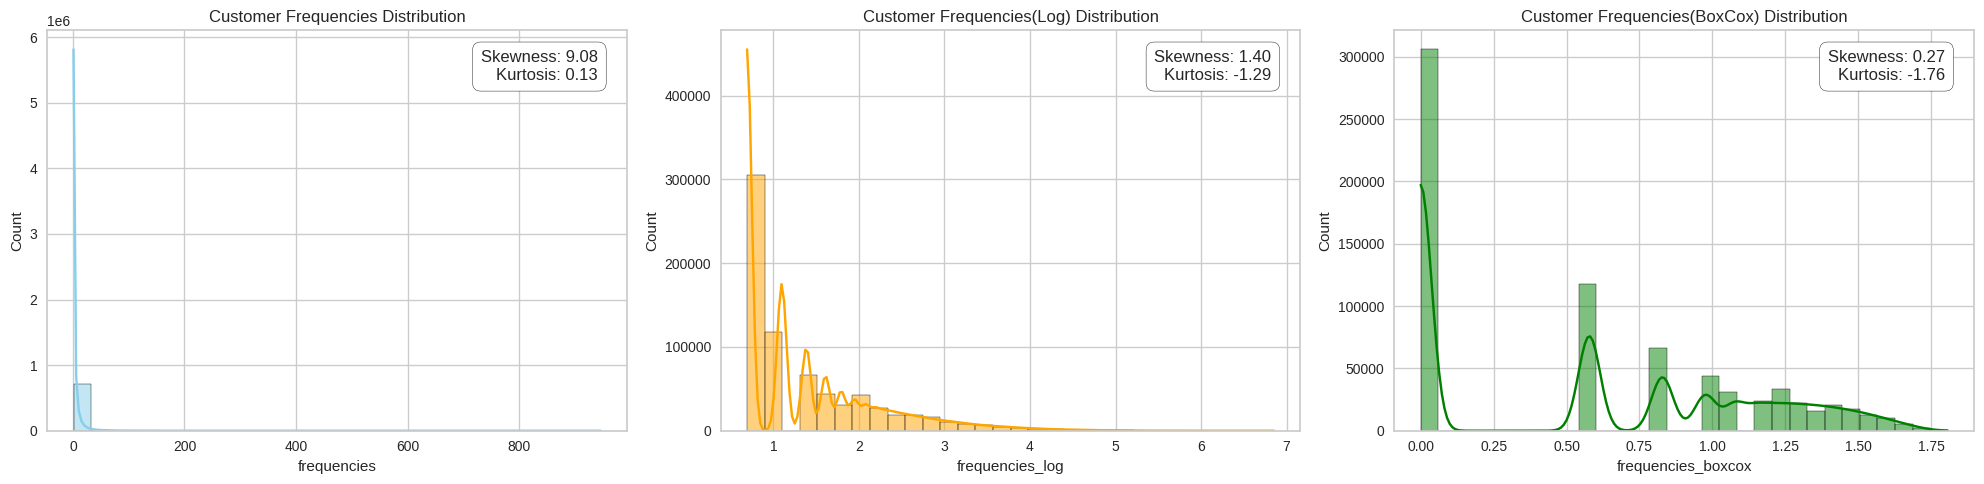

In [29]:
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(20,5))

ax1 = sns.histplot(data=frequency_df, x='frequencies', kde=True, bins=30, ax=ax1, color='skyblue')
ax1.set_title('Customer Frequencies Distribution')

ax1.text(
    0.95, 0.95,
    f"Skewness: {frequency_skewness:.2f}\nKurtosis: {recency_kurtosis:.2f}",
    transform=ax1.transAxes,
    fontsize=12,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)


ax2 = sns.histplot(data=frequency_df, x='frequencies_log', kde=True, bins=30, ax=ax2, color='orange')
ax2.set_title('Customer Frequencies(Log) Distribution')

ax2.text(
    0.95, 0.95,
    f"Skewness: {frequency_log_skewness:.2f}\nKurtosis: {recency_sqrt_kurtosis:.2f}",
    transform=ax2.transAxes,
    fontsize=12,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)


ax3 = sns.histplot(data=frequency_df, x='frequencies_boxcox', kde=True, bins=30, ax=ax3, color='green')
ax3.set_title('Customer Frequencies(BoxCox) Distribution')

ax3.text(
    0.95, 0.95,
    f"Skewness: {frequency_boxcox_skewness:.2f}\nKurtosis: {recency_log_kurtosis:.2f}",
    transform=ax3.transAxes,
    fontsize=12,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)

plt.tight_layout()

The chart compares customer frequency distributions before and after transformation:

* **Original (Left)**: Extremely right-skewed (Skewness = 9.08, Kurtosis = 0.13), with most customers having very low purchase counts.
* **Log Transformation (Middle)**: Skewness reduced to 1.40, but the distribution still shows a long tail.
* **Box-Cox Transformation (Right)**: Best normalization achieved (Skewness = 0.27, Kurtosis = -1.76), resulting in a more symmetric and compact shape.

**Box-Cox transformation** is the most effective in normalizing customer frequency, making it more suitable for further analysis like clustering.


**Customer Monetary**

In [30]:
monetary_df = orders_df.groupby(by='customer_id', as_index=False).agg(
    total_monetary_val=('sales_amount', 'sum'),
    average_monetary_val=('sales_amount', 'mean')
    )
monetary_df.head()

,customer_id,total_monetary_val,average_monetary_val
0,1000015,158.11,39.527500
1,100002,334.03,16.701500
2,1000020,52.10,8.683333
3,1000029,838.79,15.250727
4,1000035,125.11,15.638750


In [31]:
print('minimum total monetary val: ', monetary_df['total_monetary_val'].min())
print('maximum total monetary val: ', monetary_df['total_monetary_val'].max())
print('minimum avg monetary val: ', monetary_df['average_monetary_val'].min())
print('maximum avg monetary val: ', monetary_df['average_monetary_val'].max())

minimum total monetary val:  3.11
maximum total monetary val:  11394.85
minimum avg monetary val:  3.11
maximum avg monetary val:  518.4


* **Total Monetary Value** ranges from **3.11** to **11,394.85**, indicating that some customers have made significantly large cumulative purchases.
* **Average Monetary Value** ranges from **3.11** to **518.40**, suggesting that while some customers spend heavily on average per purchase, most likely spend modest amounts.

In [32]:
print(f"Skewness of the total monetary distribution: {skew(monetary_df['total_monetary_val'])}")
print(f"Kurtosis of the total monetary distribution: {kurtosis(monetary_df['total_monetary_val'])}")

print(f"Skewness of the average monetary distribution: {skew(monetary_df['average_monetary_val'])}")
print(f"Kurtosis of the average monetary distribution: {kurtosis(monetary_df['average_monetary_val'])}")

Skewness of the total monetary distribution: 8.731188984729583
Kurtosis of the total monetary distribution: 177.07145194279585
Skewness of the average monetary distribution: 4.842146391588488
Kurtosis of the average monetary distribution: 72.69651034549682


* **Total Monetary**

  * **Skewness: 8.73**, **Kurtosis: 177.07**
  * Indicates a heavy right skew and extreme outliers—most customers spend low amounts, while a few spend exceptionally high.

* **Average Monetary**

  * **Skewness: 4.84**, **Kurtosis: 72.70**
  * Still very right-skewed, though less extreme than total monetary. Suggests that some customers consistently make high-value purchases.


In [33]:
monetary_df['monetary_log'] = np.log1p(monetary_df['total_monetary_val'])
monetary_df['monetary_boxcox'], fitted_lambda = boxcox(monetary_df['total_monetary_val'])
print("Fitted lambda for Box-Cox:", fitted_lambda)

Fitted lambda for Box-Cox: -0.22071452418732881



1. **Log Transformation**

   * Greatly compresses high values and reduces right skew.

2. **Box-Cox Transformation**

   * More flexible than log, automatically finds the optimal transformation parameter (lambda) to normalize the distribution.

In [34]:
total_monetary_value_skewness = skew(monetary_df['total_monetary_val'])
total_monetary_value_kurtosis = kurtosis(monetary_df['total_monetary_val'])

average_monetary_value_skewness = skew(monetary_df['average_monetary_val'])
average_monetary_value_kurtosis = kurtosis(monetary_df['average_monetary_val'])

monetary_log_skewness = skew(monetary_df['monetary_log'])
monetary_log_kurtosis = kurtosis(monetary_df['monetary_log'])

monetary_boxcox_skewness = skew(monetary_df['monetary_boxcox'])
monetary_boxcox_kurtosis = kurtosis(monetary_df['monetary_boxcox'])

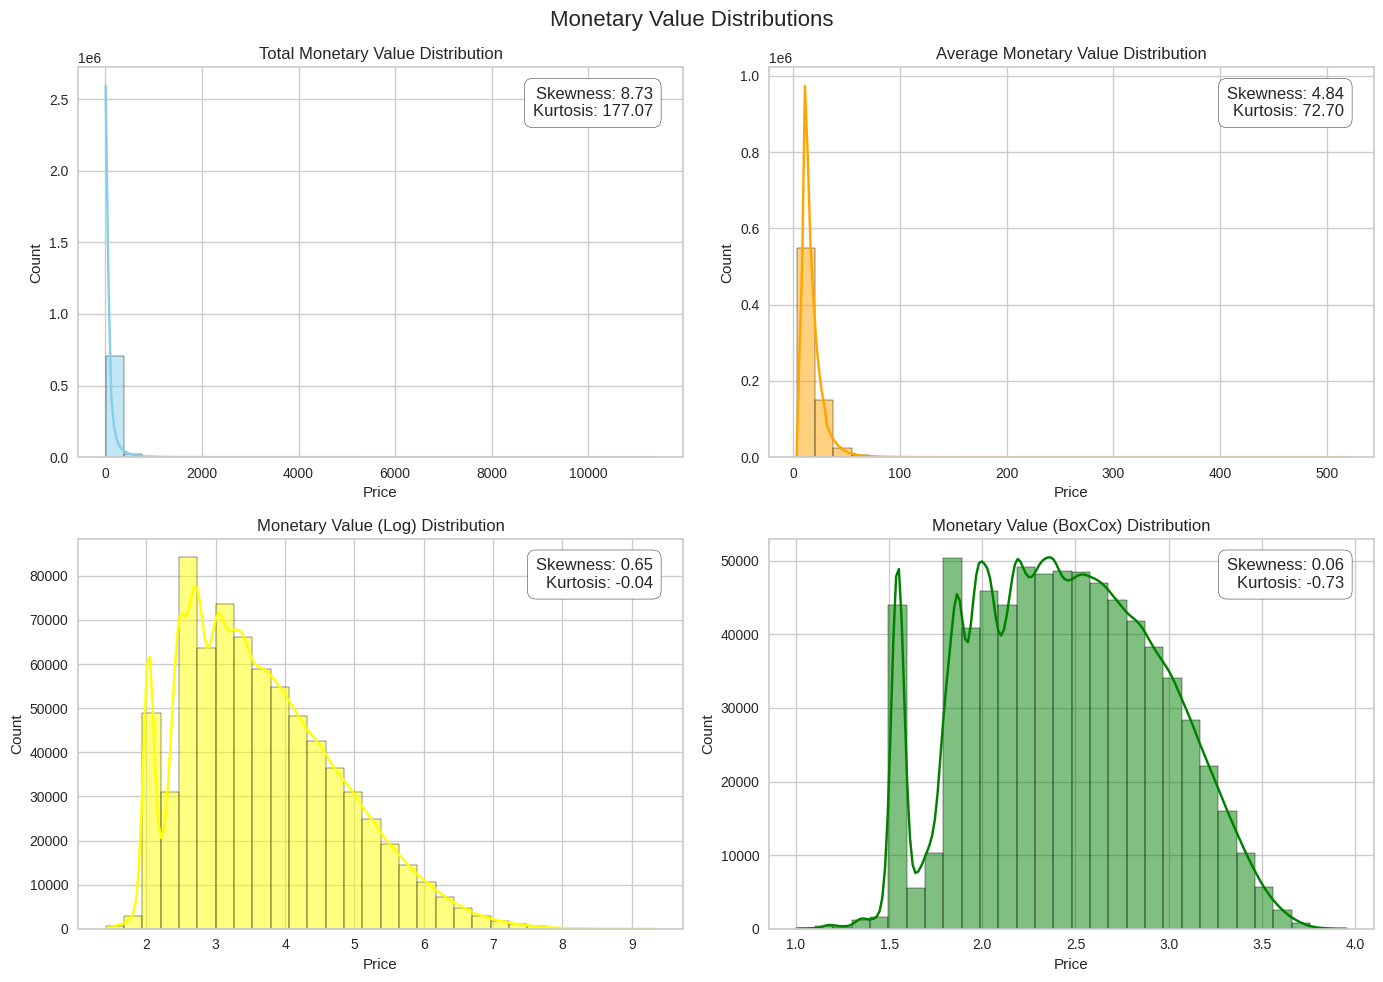

In [35]:
# Set up a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Monetary Value Distributions", fontsize=16)

# Plot for total monetary
sns.histplot(data=monetary_df, x='total_monetary_val', kde=True, bins=30, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Total Monetary Value Distribution')
axes[0, 0].set_xlabel('Price')
axes[0, 0].set_ylabel('Count')

axes[0, 0].text(
    0.95, 0.95,
    f"Skewness: {total_monetary_value_skewness:.2f}\nKurtosis: {total_monetary_value_kurtosis:.2f}",
    transform=axes[0, 0].transAxes,
    fontsize=12,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)

# Plot for avg monetary
sns.histplot(data=monetary_df, x='average_monetary_val', kde=True, bins=30, ax=axes[0, 1], color='orange')
axes[0, 1].set_title('Average Monetary Value Distribution')
axes[0, 1].set_xlabel('Price')
axes[0, 1].set_ylabel('Count')

axes[0, 1].text(
    0.95, 0.95,
    f"Skewness: {average_monetary_value_skewness:.2f}\nKurtosis: {average_monetary_value_kurtosis:.2f}",
    transform=axes[0, 1].transAxes,
    fontsize=12,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)

# Plot for monetary after log transformation
sns.histplot(data=monetary_df, x='monetary_log', kde=True, bins=30, ax=axes[1, 0], color='yellow')
axes[1, 0].set_title('Monetary Value (Log) Distribution')
axes[1, 0].set_xlabel('Price')
axes[1, 0].set_ylabel('Count')

axes[1, 0].text(
    0.95, 0.95,
    f"Skewness: {monetary_log_skewness:.2f}\nKurtosis: {monetary_log_kurtosis:.2f}",
    transform=axes[1, 0].transAxes,
    fontsize=12,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)

# Plot for monetary after boxcox transformation
sns.histplot(data=monetary_df, x='monetary_boxcox', kde=True, bins=30, ax=axes[1, 1], color='green')
axes[1, 1].set_title('Monetary Value (BoxCox) Distribution')
axes[1, 1].set_xlabel('Price')
axes[1, 1].set_ylabel('Count')

axes[1, 1].text(
    0.95, 0.95,
    f"Skewness: {monetary_boxcox_skewness:.2f}\nKurtosis: {monetary_boxcox_kurtosis:.2f}",
    transform=axes[1, 1].transAxes,
    fontsize=12,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)

plt.tight_layout()
plt.show()


The chart illustrates the effect of log and Box-Cox transformations on **total monetary value**:

* **Top Left & Top Right** (Original Distributions):
  Both total and average monetary values are **highly right-skewed** with **extreme kurtosis**, indicating the presence of outliers and heavy concentration of low values.

* **Bottom Left (Log Transformation)**:
  Skewness is reduced to **0.65** and kurtosis to **-0.04**, resulting in a smoother and more symmetrical shape, though still slightly skewed.

* **Bottom Right (Box-Cox Transformation)**:
  Achieves **near-perfect normalization** with skewness of **0.06** and kurtosis of **-0.73**. The distribution becomes much more compact and symmetric.
  
While **log transformation** provides significant improvement, the **Box-Cox transformation** is the most effective at normalizing the monetary data, making it ideal for downstream modeling or clustering tasks.


<h2>RFM Dataframe</h2>

In [36]:
rfm_df = pd.merge(recency_df[['customer_id', 'recency_log']], frequency_df[['customer_id', 'frequencies_boxcox']])
rfm_df = pd.merge(rfm_df, monetary_df[['customer_id', 'monetary_boxcox']])

In [37]:
rfm_df.head()

,customer_id,recency_log,frequencies_boxcox,monetary_boxcox
0,1000015,5.079850,0.976009,3.048812
1,100002,5.324959,1.484908,3.274325
2,1000020,4.946393,1.148324,2.637358
3,1000029,5.051137,1.639635,3.505379
4,1000035,4.966335,1.249624,2.970230


Text(0.5, 1.0, 'Box Plot of RFM Factors')

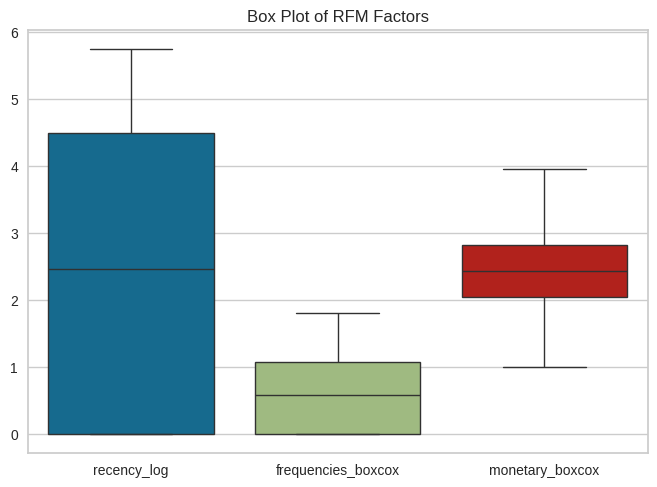

In [38]:
ax = sns.boxplot(rfm_df)
ax.set_title('Box Plot of RFM Factors')

The box plot displays the distribution of the transformed RFM factors:

* **`recency_log`** has the widest range and highest median, indicating more variability in customer recency.
* **`frequencies_boxcox`** is the most compressed, with a lower median and tighter spread.
* **`monetary_boxcox`** shows moderate spread and a relatively balanced distribution.

Despite transformations reducing skewness, the RFM factors still vary in scale.
To bring them to a common scale and ensure fair weighting in clustering, we will apply **StandardScaler** to standardize the variables (mean = 0, std = 1).


In [39]:
rfm_df = rfm_df.drop(columns='customer_id')
std_scaler = StandardScaler()
rfm_cols = rfm_df.columns
rfm_df[rfm_cols] = std_scaler.fit_transform(rfm_df[rfm_cols])

In [40]:
rfm_df.describe()

,recency_log,frequencies_boxcox,monetary_boxcox
count,7.304850e+05,7.304850e+05,7.304850e+05
mean,-7.618186e-17,1.056741e-16,1.947734e-15
std,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.055976e+00,-1.045425e+00,-2.873235e+00
25%,-1.055976e+00,-1.045425e+00,-7.797843e-01
50%,8.702281e-02,-3.342066e-03,-2.000436e-02
75%,1.028068e+00,8.927574e-01,7.570296e-01
max,1.608392e+00,2.210652e+00,3.041913e+00


Text(0.5, 1.0, 'Box Plot of Standardized RFM Factors')

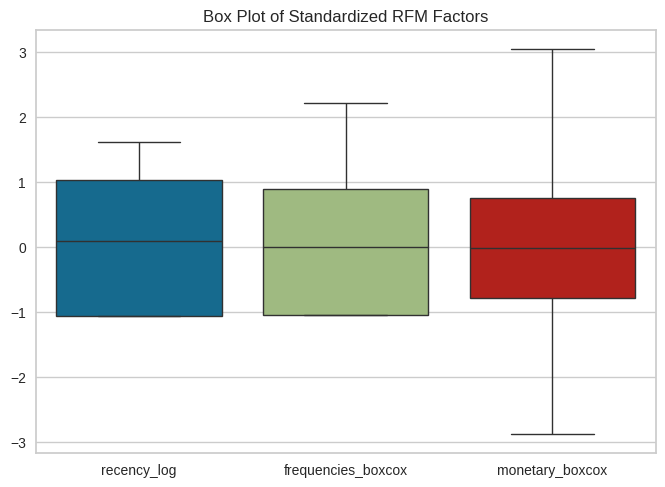

In [41]:
ax = sns.boxplot(rfm_df)
ax.set_title('Box Plot of Standardized RFM Factors')

The box plot displays the **standardized RFM factors** after applying `StandardScaler`:

* All three features—**recency\_log**, **frequencies\_boxcox**, and **monetary\_boxcox**—now have a **mean of 0** and are scaled to comparable ranges.
* The distributions appear more **balanced and centered**, ensuring that no single feature dominates due to scale differences.
* Although **monetary\_boxcox** still shows a wider spread, the standardization allows all variables to contribute equally in clustering or modeling.


<h2>K-Mean Clustering</h2>


**Elbow Method**

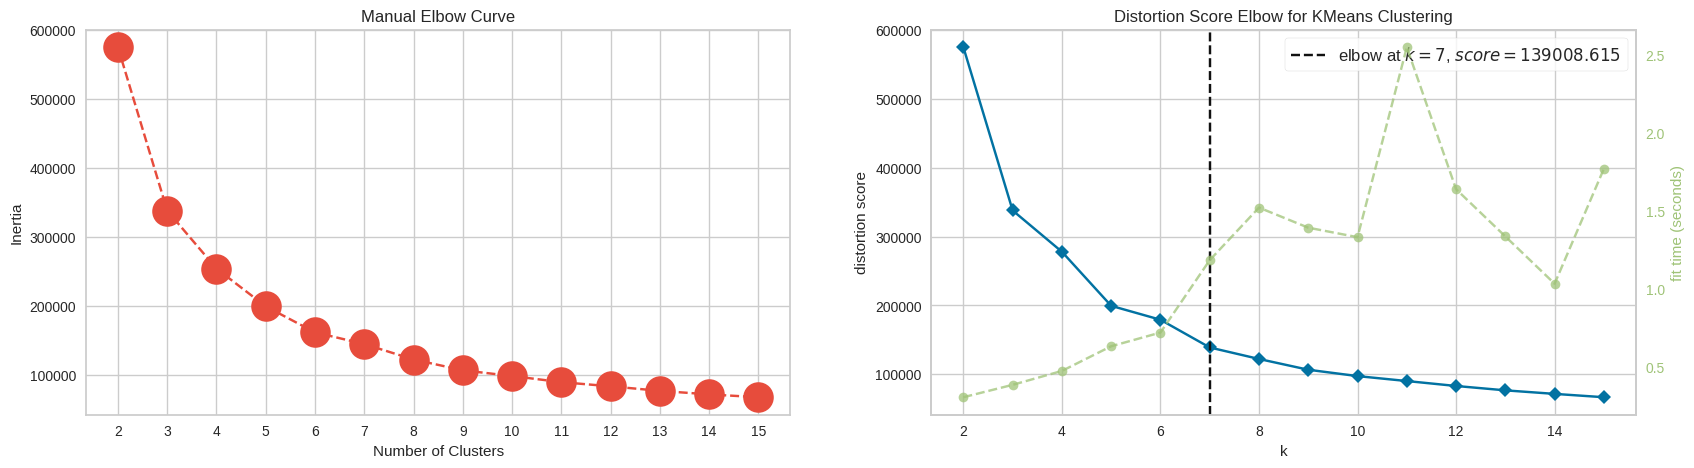

In [42]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(20,5))

kls = np.arange(2,16,1)
inertias=[]
for k in kls :
    knc = KMeans(n_clusters=k, random_state=42)
    knc.fit(rfm_df)
    inertias.append(knc.inertia_)

ax1.plot(kls, inertias,'--o', markersize=22, color='#e74c3c')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Inertia')
ax1.set_xticks(kls)
ax1.set_title('Manual Elbow Curve')

Elbow_M = KElbowVisualizer(KMeans(), k=15)
Elbow_M.fit(rfm_df)
ax2 = Elbow_M.show()


The visualizations showing both manual and automated Elbow method for determining the optimal number of clusters (`k`) in KMeans clustering:

* Both the **manual elbow curve** and automated distortion score analysis suggest a clear "elbow" at **k = 5**, where the inertia/distortion drops sharply before leveling off.
* The dashed line and annotation on the right plot reinforce that **k = 5** is a strong candidate, balancing fit quality with computational cost.


**Silhouette & DBI**

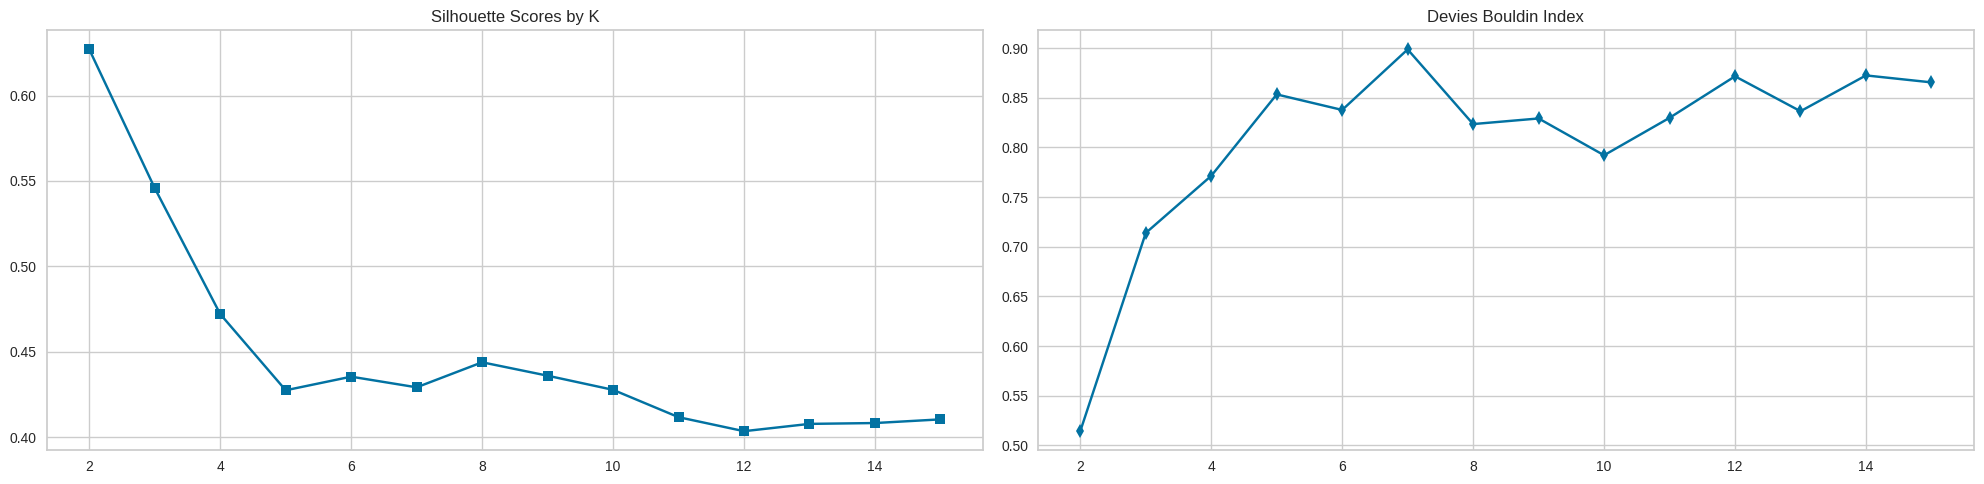

In [43]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(20,5))

silhouette_scores = []
db_idxs = []

for k in kls:
  kms = KMeans(n_clusters=k, random_state=42)
  labels = kms.fit_predict(rfm_df)
  scores = silhouette_score(rfm_df, labels, sample_size=10000, random_state=42)
  db_idx = davies_bouldin_score(rfm_df, labels)
  silhouette_scores.append(scores)
  db_idxs.append(db_idx)

ax1.plot(kls, silhouette_scores, marker='s')
ax1.set_title('Silhouette Scores by K')
ax2.plot(kls, db_idxs, marker='d')
ax2.set_title('Devies Bouldin Index')

plt.tight_layout()


### **Silhouette Score**

* The **highest silhouette score** occurs at **k = 2**, but such a small number of clusters may oversimplify customer segments.
* **k = 5** still maintains a **reasonable silhouette score (\~0.47)**, suggesting fair separation between clusters.

### **Davies-Bouldin Index**

* Lower values indicate better clustering. While **k = 2** performs best, the index rises and fluctuates beyond that.
* Around **k = 5**, the index is **moderate (\~0.85)**, which supports its selection as a balanced option.

Across all metrics—**elbow, silhouette, and Davies-Bouldin index**—**`k = 5`** emerges as a reasonable and balanced choice. It captures meaningful structure in the data while avoiding overfitting or excessive fragmentation.

In [44]:
LABELS = rfm_df.columns

In [59]:
def plot_clustering_results(k: int, LABELS: List[str], rfm_df: pd.DataFrame):
    # Initiating KMeans. n_clusters = k
    kms = KMeans(n_clusters=k, n_init=10, random_state=42)

    # Fit model and predict clusters
    yhat = kms.fit_predict(rfm_df[LABELS])
    rfm_df[f"{k}_clusters_2D"] = yhat

    # Initiating PCA to reduce dimensions to 2
    pca = PCA(n_components=2, random_state=42)
    pca.fit(rfm_df[LABELS])

    data_cluster_2D = pd.DataFrame(pca.transform(rfm_df[LABELS]), columns=["col1", "col2"])
    data_cluster_2D["clusters_2D"] = yhat

    cluster_count = data_cluster_2D.groupby("clusters_2D")["clusters_2D"].count().reset_index(name='count')

    fig, axes = plt.subplots(2, 2, figsize=(20, 10))

    ### Heatmap of cluster centers ###
    k_cluster_data = pd.DataFrame(kms.cluster_centers_, columns=LABELS)
    axes[0, 0] = sns.heatmap(data=k_cluster_data, cmap='RdBu', annot=True, ax=axes[0, 0])
    axes[0, 0].set_title('Cluster Centers', fontsize=15)

    ### Table view of cluster_count ###
    axes[0, 1].axis('off')  # turn off axes
    table_data = cluster_count.values
    col_labels = cluster_count.columns
    axes[0, 1].table(cellText=table_data, colLabels=col_labels, cellLoc='center', loc='center')
    axes[0, 1].set_title("Cluster Size Table", fontsize=15)

    ### Barplot of cluster distribution ###
    axes[1, 0] = sns.barplot(x='clusters_2D', y='count', data=cluster_count, palette='Spectral', ax=axes[1, 0])
    axes[1, 0].set_xlabel("cluster number", fontsize=15)
    axes[1, 0].set_ylabel('count', fontsize=15)
    axes[1, 0].set_title("Numerical Distribution of the Clusters", fontsize=15)

    ### 2D scatterplot of clusters ###
    axes[1, 1] = sns.scatterplot(x="col1", y="col2", data=data_cluster_2D, hue="clusters_2D", palette='Spectral', ax=axes[1, 1])
    axes[1, 1].set_title("2D Representation of the Clusters with PCA", fontsize=15)
    legend_handles,_ = axes[1, 1].get_legend_handles_labels()

    plt.tight_layout()
    plt.suptitle(f'{k} Clusters', fontsize=18)

def tsne_visual(k: int, rfm_df: pd.DataFrame, sample_size: Optional[int]):
    # Fit KMeans
    kms = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kms.fit_predict(rfm_df)

    # Combine data with labels
    rfm_df['cluster'] = labels

    # Stratified sampling
    if sample_size is not None:
      sampled_df = pd.concat([
          group.sample(n=sample_size, random_state=42)
          for _, group in rfm_df.groupby('cluster')
          ], ignore_index=True)
    else:
      sampled_df = pd.concat([
          group.sample(frac=0.02, random_state=42)
          for _, group in rfm_df.groupby('cluster')
      ], ignore_index=True)

    # Run t-SNE only on sampled data
    tsne = TSNE(n_components=2, random_state=42)
    data_tsne = tsne.fit_transform(sampled_df.drop(columns='cluster'))

    # Make DataFrame
    df_tsne = pd.DataFrame(data_tsne, columns=['component 1', 'component 2'])
    df_tsne['cluster'] = sampled_df['cluster'].values

    # Plot
    sns.scatterplot(x='component 1', y='component 2', data=df_tsne, hue='cluster', palette='Set2')
    plt.title(f"2D t-SNE Visualization (Stratified Sample, n = {sample_size})", fontsize=16)
    plt.show()


/tmp/ipython-input-52-2942744993.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  axes[1, 0] = sns.barplot(x='clusters_2D', y='count', data=cluster_count, palette='Spectral', ax=axes[1, 0])
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


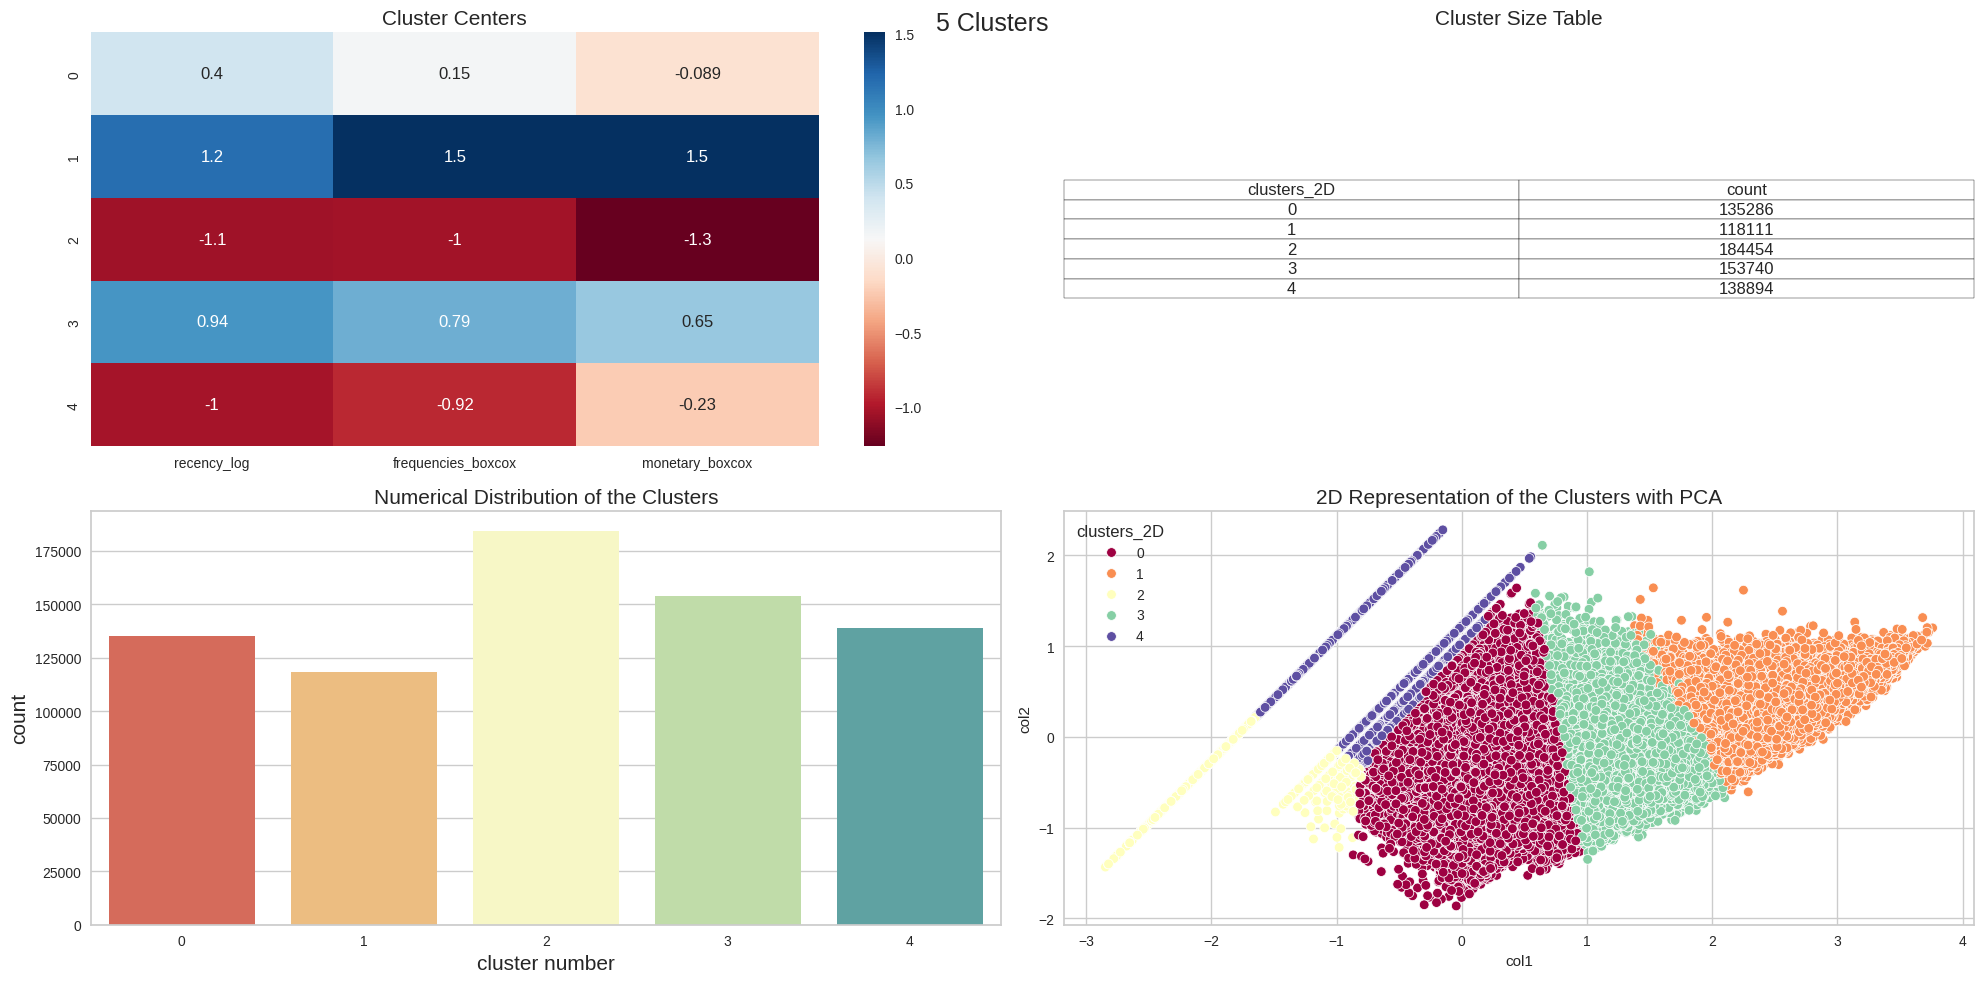

In [53]:
plot_clustering_results(k=5, LABELS=LABELS, rfm_df=rfm_df)

The visualization summarizes the KMeans clustering result with **5 customer segments** based on RFM features:


### Cluster Centers

* Shows standardized RFM scores for each cluster.
* **Cluster 1** stands out with **high frequency and monetary values**, representing the **most valuable customers**.
* **Cluster 2** has **low recency, frequency, and monetary** values—likely **inactive or low-value** customers.
* **Cluster 3** has above-average scores across all factors, indicating **moderately engaged customers**.
* **Cluster 4** is also relatively inactive but with slightly better monetary behavior than Cluster 2.
* **Cluster 0** represents average/neutral behavior.

### Cluster Size Table & Bar Plot

* The clusters are fairly balanced.
* **Cluster 2** is the largest segment (\~184k customers), followed by Clusters 3, 0, 4, and 1.
* This indicates a large base of low-value or inactive customers (Cluster 2) and fewer high-engagement customers (Cluster 1).

### 2D PCA Plot

* Provides a visual separation of clusters in 2D space.
* Clear boundaries between clusters suggest meaningful segmentation.


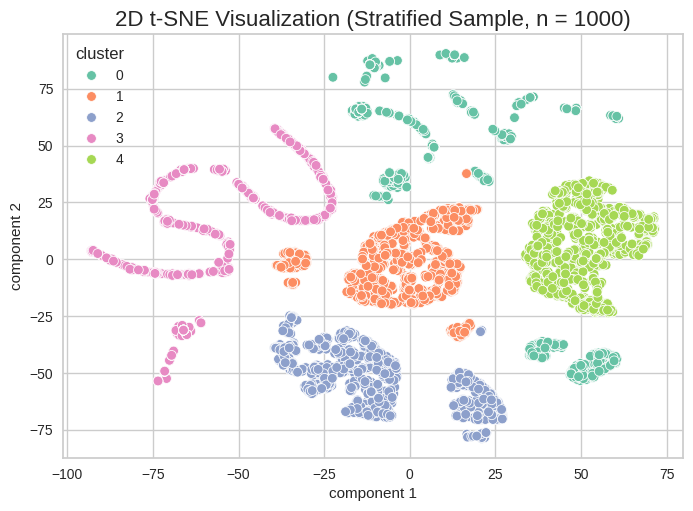

In [58]:
tsne_visual(k=5, rfm_df=rfm_df, sample_size=1000)

The chart shows a **2D t-SNE visualization** of the KMeans clusters based on a **stratified sample of 1,000 customers**:

* Clusters are **visibly well-separated**, confirming meaningful groupings in high-dimensional space.
* **Cluster 1 (orange)** and **Cluster 4 (green)** form **dense, compact groups**, suggesting highly distinct behavior patterns.
* **Cluster 0 (teal)** and **Cluster 3 (pink)** appear more **dispersed or fragmented**, potentially capturing more diverse customer profiles.
* **Cluster 2 (blue)** is tightly grouped, indicating **strong intra-cluster similarity**.

t-SNE further confirms that the **5-cluster KMeans solution** reflects clear behavioral segmentation, particularly for high-value or consistent customers. This visualization supports the validity of the clustering results for strategic targeting and personalization.


<h2> Conclusion </h2>

The clustering model with **k=5** successfully differentiates customer segments with distinct behavioral patterns. These insights can guide personalized marketing strategies such as:

* **Rewarding Cluster 1** (high value),
* **Re-engaging Cluster 2** (low activity),
* **Upselling to Clusters 0 and 3**, and
* **Monitoring Cluster 4** for churn risk.